**ASSIGNMENT-102303493**

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

Load Data

In [2]:
df = pd.read_csv('data.csv',encoding='latin-1',low_memory=False)
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [3]:
x = df["no2"]
x = x[x >= 0]
x.dropna()
x.describe()

count    419509.000000
mean         25.809623
std          18.503086
min           0.000000
25%          14.000000
50%          22.000000
75%          32.200000
max         876.000000
Name: no2, dtype: float64

**STEP 1**

Transform the data

In [4]:

r = 102303493
a_r = 0.5*(r%7)
b_r = 0.3*((r%5)+1)

z = x + a_r*np.sin(b_r*x)
z_tensor = torch.FloatTensor(z).reshape(-1,1)
z_tensor.shape

torch.Size([419509, 1])

**STEP 2**

Make the Generator and Discriminator

In [5]:
class PDFGEn(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Linear(1,128),
            torch.nn.LeakyReLU(0.2,inplace=True),
            torch.nn.Linear(128,256),
            torch.nn.LeakyReLU(0.2,inplace=True),
            torch.nn.Linear(256,1)
        )
    def forward(self,x):
        return self.main(x)
    
class PDFDisc(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Linear(1,256),
            torch.nn.LeakyReLU(0.2,inplace=True),
            torch.nn.Linear(256,128),
            torch.nn.LeakyReLU(0.2,inplace=True),
            torch.nn.Linear(128,1),
            torch.nn.Sigmoid()
        )

    def forward(self,x):
        return self.main(x)
    
mG ,mD = PDFGEn(), PDFDisc()
Goptim = torch.optim.Adam(mG.parameters(),lr=1e-4,betas=(0.5,0.9))
Doptim = torch.optim.Adam(mD.parameters(),lr=1e-4,betas=(0.5,0.9))
loss_fn = torch.nn.BCELoss()

Train the GAN

In [6]:
iters = 15000
batch = 64

for i in range(iters):
    mD.zero_grad()
    pick = torch.randint(0,len(z_tensor),(batch,))
    real_b = z_tensor[pick]
    lbl_r = torch.ones(batch,1)

    out_r = mD(real_b)
    errD_r = loss_fn(out_r,lbl_r)
    
    latent = torch.randn(batch,1)
    fake_b = mG(latent)
    lbl_f = torch.zeros(batch,1)
    out_f = mD(fake_b.detach())
    errD_f = loss_fn(out_f,lbl_f)

    (errD_r + errD_f).backward()
    Doptim.step()

    mG.zero_grad()
    out_g = mD(fake_b)
    errG = loss_fn(out_g,lbl_r)
    errG.backward()
    Goptim.step()

    if i%3000==0:
        print(f"Iter: {i} \t D Loss: {errD_r.item()+errD_f.item()} \t G Loss: {errG.item()}")

Iter: 0 	 D Loss: 1.5870354175567627 	 G Loss: 0.7087938785552979
Iter: 3000 	 D Loss: 1.4190670251846313 	 G Loss: 0.8746538162231445
Iter: 6000 	 D Loss: 1.3916648030281067 	 G Loss: 0.7711045742034912
Iter: 9000 	 D Loss: 1.3858458399772644 	 G Loss: 0.7837405800819397
Iter: 12000 	 D Loss: 1.3996555805206299 	 G Loss: 0.6799570918083191


Eval and Plotting

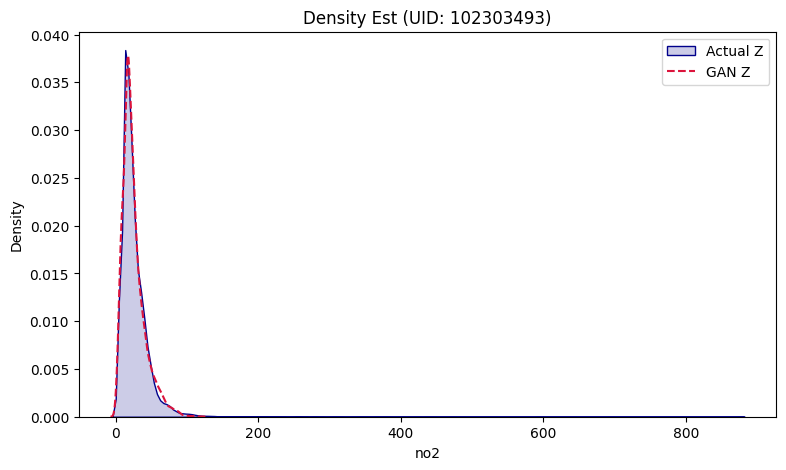

In [7]:
mG.eval()
with torch.no_grad():
    res_z = mG(torch.randn(10000, 1)).numpy()

plt.figure(figsize=(9, 5))
sns.kdeplot(z, label='Actual Z', color='darkblue', fill=True, alpha=0.2)
sns.kdeplot(res_z.flatten(), label='GAN Z', color='crimson', ls='--')
plt.title(f"Density Est (UID: {r})")
plt.legend()
plt.show()